In [29]:
%tensorflow_version 1.x

_git_branch = 'trainset'

import tensorflow as tf
print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


# Import code from gitHub

In [30]:
import json
import subprocess
import sys
import time

import numpy as np
from IPython.core.display import display, HTML
from google.colab import files

!pip install overrides
!pip install pyjarowinkler
 
def exec(x):
  r = subprocess.check_output(x, shell=True)
  r = r.decode('unicode-escape').encode('latin1').decode('utf8')
  print(r)


print(f"fetching code from GitHub.....{_git_branch}")
try:
  exec('rm -r nlp_tools')
except:
  pass
exec(f'git clone --single-branch --branch {_git_branch} https://github.com/nemoware/analyser.git nlp_tools')

print('🦊 GIT revision:')
exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

sys.path.insert(0, 'nlp_tools')

print('❤️importing Code from GitHub ... DONE')

#----- other deps

import nltk
nltk.download('punkt')

fetching code from GitHub.....trainset


🦊 GIT revision:
1302
* trainset
Testing model loading

Keras model loading

Misaine import


❤️importing Code from GitHub ... DONE
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_emb(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 6))
    ax = sns.heatmap(mt, square=False,  cmap="RdYlBu", center=0)
    plt.show()

#Prepare trainset


#### Mount drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read meta

In [33]:
import pandas as pd
from os import path


TRAINSETS_PATH='/content/drive/My Drive/GazpromOil/trainsets'
VERSION_PATH='1_1_19'
TRAINSET_META_FN='contracts.subjects-manually-filtered.csv'

csv_path = path.join(TRAINSETS_PATH, 'meta_info', TRAINSET_META_FN)

trainset_meta = pd.read_csv(csv_path, encoding='utf-8' )
trainset_rows = trainset_meta[trainset_meta['valid']]
print(trainset_rows.info())
# trainset_rows.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 280 to 789
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   idx          510 non-null    int64  
 1   section      510 non-null    object 
 2   subject      510 non-null    object 
 3   confidence   510 non-null    float64
 4   valid        510 non-null    bool   
 5   header       510 non-null    object 
 6   _id          510 non-null    object 
 7   len          510 non-null    int64  
 8   pickle       510 non-null    object 
 9   org-1-alias  404 non-null    object 
 10  org-2-alias  341 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 44.3+ KB
None


###  One-1-hots: subject codes -> `subject_name_1hot_map`

(33, 43)
dict_keys(['Other', 'Deal', 'Charity', 'RealEstate', 'Loans', 'BigDeal', 'Lawsuit', 'Insurance', 'Consulting', 'RentingOut', 'Renting', 'AgencyContract', 'BankGuarantees', 'RelatedTransactions', 'GeneralContract', 'EmployeeContracts', 'PledgeEncumbrance', 'Liquidation', 'Service', 'CashPayments', 'RefusalToLeaseLand', 'DealGeneralBusiness', 'RevisionCommission', 'Reorganization', 'InterestedPartyTransaction', 'RelatedPartyTransaction', 'AssetTransactions', 'DealIntellectualProperty', 'RealEstateTransactions', 'SecuritiesTransactions', 'RegisteredCapital', 'ParticipationInOtherOrganizations', 'DecisionsForSubsidiary'])


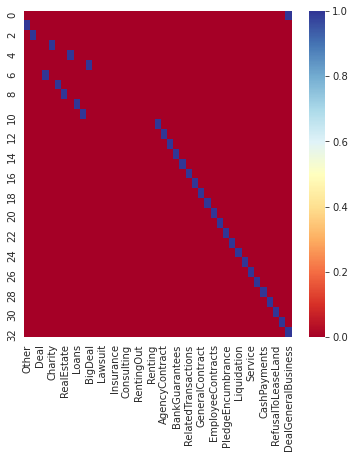

In [34]:

from analyser.structures import ContractSubject
from keras.utils import to_categorical


all_subjects_map ={s.name : s.value  for s in ContractSubject}

# encoding integer subject codes in one-hot vectors
_cats = to_categorical( list(all_subjects_map.values()) )
print(_cats.shape)
print(all_subjects_map.keys())

subject_name_1hot_map={}
for i, k in enumerate(all_subjects_map.keys()):  
  subject_name_1hot_map[k] = _cats[i]

# debug: render all onne-hots as a marix
# plot_emb( np.array( list(  subject_name_1hot_map.values())))

mt = np.array(list( subject_name_1hot_map.values()))
with sns.axes_style("white"):
  plt.figure(figsize=(6, 6))
  ax = sns.heatmap(mt, square=False,  cmap="RdYlBu")
  ax.set_xticklabels(all_subjects_map.keys())
  plt.show()
 

### Balance trainset
TODO: consider https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

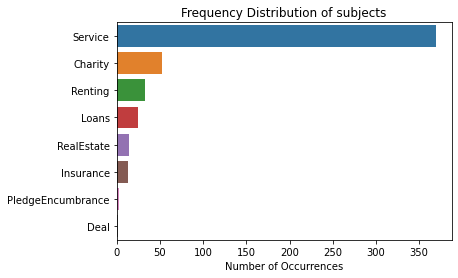


min 1
max 369
total 510
mean length is 1007.2392156862745


In [35]:


subj_count = trainset_rows['subject'].value_counts()

#plot distribution
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

print('mean length is', trainset_rows['len'].mean())

#### Group by subjects (put row indices into bags)

1. distribute row numbers by bags
2. oversample each bag

In [36]:
#make empty bags
# subject_bags = {}
# for key in subj_count.index:
#   subject_bags[key]=[]

subject_bags = {key: [] for key in subj_count.index}
print(subject_bags)


row_no:int = 0
for index, row in trainset_rows.iterrows():

  row_by_no = trainset_rows.iloc[row_no]
  subj_code = row["subject"]
  bag = subject_bags[subj_code]
  bag.append(row_no)
  
  row_no += 1


# --- debug
print('sample bag ')
subject_bags['PledgeEncumbrance']

{'Service': [], 'Charity': [], 'Renting': [], 'Loans': [], 'RealEstate': [], 'Insurance': [], 'PledgeEncumbrance': [], 'Deal': []}
sample bag 


[91, 92, 93]

2. oversample with np.tile: just repeat the indices stored in named bags. 



In [37]:
_desired_number_of_samples = max (subj_count.values)
for subj_code in subject_bags:
  bag = subject_bags[subj_code]
  if len(bag)<_desired_number_of_samples:  
    repeats = int(_desired_number_of_samples / len(bag))
    bag = sorted(np.tile(bag, repeats))
    subject_bags[subj_code] = bag
  print (subj_code, len(bag))

print()
print('sample bag after oversampling:', subject_bags['PledgeEncumbrance'])


Service 369
Charity 364
Renting 363
Loans 350
RealEstate 364
Insurance 364
PledgeEncumbrance 369
Deal 369

sample bag after oversampling: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9

split all bags into train and validation sets

In [38]:
REVERSE_TRAIN_AND_TEST_SETS=True
VALIDATION_SET_PROPORTION = 0.22

subject_bags_test = {}
subject_bags_train = {}

train_indices = []
test_indices = []

for subj_code in subject_bags:
  bag = subject_bags[subj_code]
  if REVERSE_TRAIN_AND_TEST_SETS:
    bag = list(reversed(bag))

  split_index:int = int(len(bag) * VALIDATION_SET_PROPORTION)
  #print(split_index)
  
  subject_bags_train [subj_code] = bag[split_index:]
  train_indices += subject_bags_train [subj_code];

  subject_bags_test [subj_code] = bag[:split_index]
  test_indices += subject_bags_test [subj_code];
  
#--------------------------------------------------------debug
print('\n--subject_bags_train')
for subj_code in subject_bags_train:
  bag = subject_bags_train[subj_code]  
  print (subj_code, len(bag), bag[:10], "...")

print('\n--subject_bags_test')
for subj_code in subject_bags_test:
  bag = subject_bags_test[subj_code]  
  print (subj_code, len(bag), bag[:10], "...")

print()
print('Number of  test_indices: ', len(test_indices))
print('Number of train_indices:', len(train_indices))
print()
print('--Documents included both in train and validation set')
np.intersect1d(test_indices, train_indices)


--subject_bags_train
Service 288 [428, 427, 426, 425, 424, 423, 422, 421, 420, 419] ...
Charity 284 [40, 40, 40, 40, 39, 39, 39, 39, 39, 39] ...
Renting 284 [133, 133, 133, 133, 133, 133, 133, 133, 133, 132] ...
Loans 273 [85, 85, 85, 85, 85, 85, 85, 84, 84, 84] ...
RealEstate 284 [104, 104, 104, 104, 104, 104, 104, 104, 104, 104] ...
Insurance 284 [63, 63, 63, 63, 62, 62, 62, 62, 62, 62] ...
PledgeEncumbrance 288 [93, 93, 93, 93, 93, 93, 93, 93, 93, 93] ...
Deal 288 [52, 52, 52, 52, 52, 52, 52, 52, 52, 52] ...

--subject_bags_test
Service 81 [509, 508, 507, 506, 505, 504, 503, 502, 501, 500] ...
Charity 80 [51, 51, 51, 51, 51, 51, 51, 50, 50, 50] ...
Renting 79 [140, 140, 140, 140, 140, 140, 140, 140, 140, 140] ...
Loans 77 [90, 90, 90, 90, 90, 90, 90, 90, 90, 90] ...
RealEstate 80 [107, 107, 107, 107, 107, 107, 107, 107, 107, 107] ...
Insurance 80 [65, 65, 65, 65, 65, 65, 65, 65, 65, 65] ...
PledgeEncumbrance 81 [93, 93, 93, 93, 93, 93, 93, 93, 93, 93] ...
Deal 81 [52, 52, 52, 52, 5

array([ 40,  52,  63,  85,  93, 104, 133])

## Batch generator

- [x] TODO: ~~try different embedding padding~~ --> not better =(
- [x] TODO: ~~the amount of noise in embedding may depend on popularity of class subject)~~ -->.. hm.. seems like it works
- [x] TODO: try `padded_batch` --> done. 
- [ ] TODO: select min or mean emb length in batch to pad batches
- [ ] TODO: add outliers to the trainset

In [0]:
MAX_SEQUENCE_LENGTH = 800 # mind that mean lenght is 1000
RANDOMIZE_EMB_PADDING = False

embeddings_cache = {}


In [40]:
def _noise_amount( subj ):
  subj_popularity = subj_count[subj]
  max_pop = max (subj_count.values)
  return 1 - subj_popularity/max_pop

## debug ------
print()
for key in subj_count.index:
  print(key, _noise_amount(key))


Service 0.0
Charity 0.8590785907859079
Renting 0.9105691056910569
Loans 0.9322493224932249
RealEstate 0.962059620596206
Insurance 0.964769647696477
PledgeEncumbrance 0.991869918699187
Deal 0.997289972899729


In [0]:
import numpy as np
import random
import pickle
from keras.preprocessing.sequence import pad_sequences

from analyser.legal_docs import LegalDocument

EMB_NOISE_AMOUNT = 0.05 #02

def noise_embedding(emb, var=EMB_NOISE_AMOUNT):
  _mean = 0
  sigma = var**0.5
  gauss = np.random.normal(_mean, sigma, emb.shape)
  return emb + gauss


def get_embeddings_raw(filename):
  if filename not in embeddings_cache:
    with open(filename, "rb") as pickle_in:
      doc: LegalDocument = pickle.load(pickle_in)
      embeddings_cache[filename] = doc.embeddings

  return embeddings_cache[filename]
   

def get_embeddings(filename:str, subj:str, randomize=False):

  embedding = get_embeddings_raw(filename)
  # padding: String, 'pre' or 'post': pad either before or after each sequence.
  # padding = 'post'
  # if randomize and RANDOMIZE_EMB_PADDING:
  #   padding = random.choice( ['pre', 'post'] )
  
  # deprected
  # embedding = pad_sequences( [embedding], maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=padding )[0]
  
  if randomize:
    _var = EMB_NOISE_AMOUNT * _noise_amount(subj)
    embedding = noise_embedding(embedding, var=_var)

  return embedding

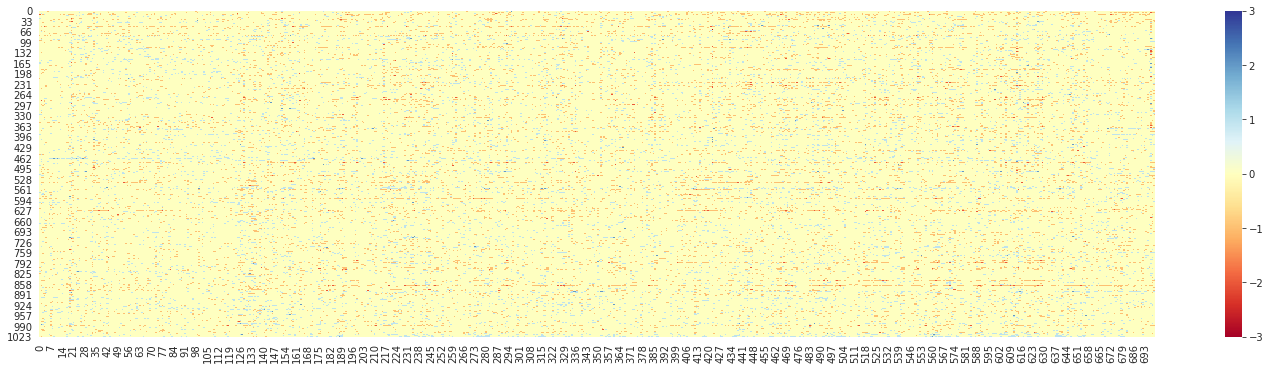

In [42]:
def subj_batch_generator(batch_size, all_indices, randomize=False):
  while True:
    # Select files (paths/indices) for the batch
    batch_indices = np.random.choice(a=all_indices, size=batch_size)

    batch_input = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in batch_indices:
      _row = trainset_rows.iloc[i]
      _subj = _row['subject']
      _filename = _row['pickle']
      _emb = get_embeddings(_filename, _subj, randomize=randomize )

      _subject_emb = subject_name_1hot_map[_subj]

      batch_input += [_emb]
      batch_output += [_subject_emb]

    # Return a tuple of (input, output) to feed the network    
    # batch_x = np.array(batch_input)
    # TODO: "randomize" MAX_SEQUENCE_LENGTH
    maxlen = random.choice( [700, 800, 900, 1000, 1100] )
    batch_x = np.array(pad_sequences( batch_input, maxlen=maxlen, padding='post', truncating='post' )).reshape(batch_size, maxlen, 1024)
    batch_y = np.array(batch_output)

    yield (batch_x, batch_y)


# ---- debug ---
_t_generator = subj_batch_generator(2, all_indices = [0], randomize=True)
_t_x, _t_y =  next(_t_generator)
del _t_generator

plot_emb(_t_x[0])

sample (48, 900, 1024)
sample (48, 43)


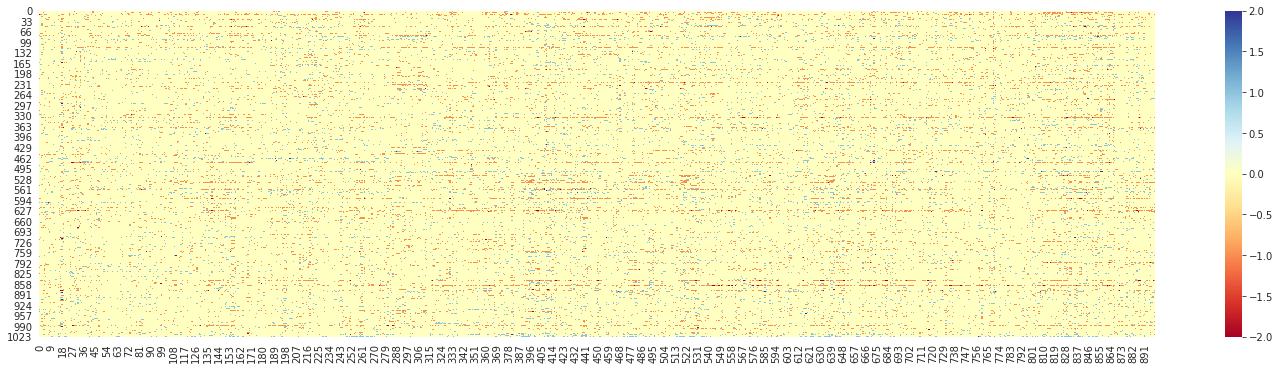

-2
2


In [43]:
EPOCHS=20
BATCH_SIZE=48
EMB=1024 #;//X.shape[-1]

CLASSES=len(list(subject_name_1hot_map.values())[0])


#create gens
test_generator = subj_batch_generator(BATCH_SIZE, all_indices = test_indices, randomize=True)
next(test_generator)

train_generator = subj_batch_generator(BATCH_SIZE, all_indices = train_indices, randomize=True)
next(train_generator)

# all_generator = subj_batch_generator(BATCH_SIZE, all_indices = train_indices+test_indices)
# next(all_generator)

#debug ---------------------
_t_x, _t_y =  next(test_generator)
print("sample", _t_x.shape)
print("sample", _t_y.shape)

plot_emb(_t_x[1])
print(_t_x[1].min())
print(_t_x[1].max())

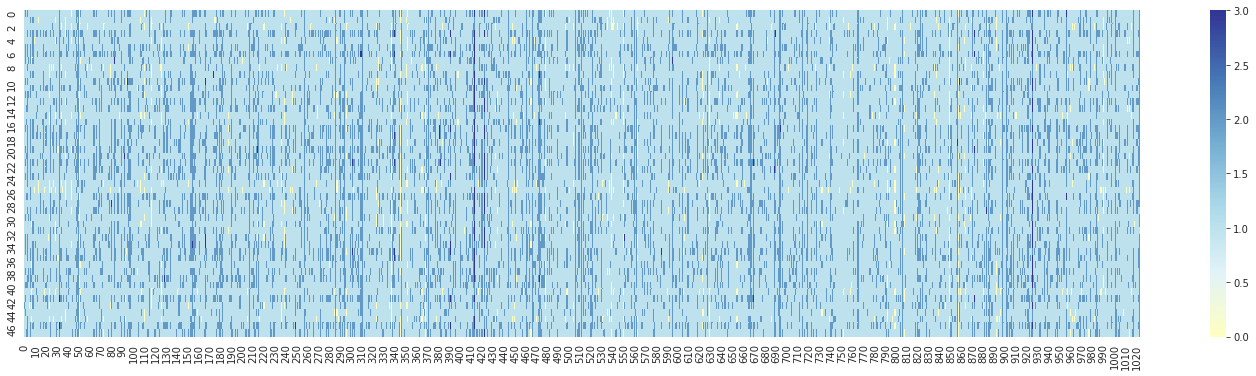

In [44]:

plot_emb(_t_x.max(axis=1).T)
# plot_emb(_t_x.mean(axis=1).T)

# Build Models

### common

In [45]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from IPython.display import SVG


from tensorflow import keras
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout
from keras.models import Sequential, Model
 
  


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [0]:
HISTORIES={}

def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  

def plot_compare_models():
  for key in HISTORIES:
    history=HISTORIES[key]
#     plt.plot(history.history['loss'], label=f'{key} loss')
    plt.plot(history.history['val_loss'], label=f'{key} val_loss')
  
  plt.title('Models loss')   
  plt.legend(loc='upper left')
  plt.show()

In [47]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from os import mkdir

model_checkpoint_path = path.join(TRAINSETS_PATH, 'checkpoints', VERSION_PATH)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1E-6, verbose=1)

print('model_checkpoint_path', model_checkpoint_path)
 


model_checkpoint_path /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19


In [48]:

validation_steps = int(len(test_indices)/BATCH_SIZE)
steps_per_epoch = int(len(train_indices)/BATCH_SIZE/2)

print('validation_steps=', validation_steps)
print('steps_per_epoch=', steps_per_epoch)

def train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator):
  print(f'MAX_SEQUENCE_LENGTH={MAX_SEQUENCE_LENGTH}')
  print(f'RANDOMIZE_EMB_PADDING={RANDOMIZE_EMB_PADDING}')
  print(f'EMB_NOISE_AMOUNT={EMB_NOISE_AMOUNT}')
  print(f'model.name={model.name}')


  checkpoint = ModelCheckpoint( path.join(model_checkpoint_path, model.name), 
                               monitor='val_loss', mode='min', save_best_only=True,
                               verbose=1) 
  history = model.fit_generator(
      generator=generator, 
      epochs=EPOCHS,  callbacks=[reduce_lr, checkpoint], steps_per_epoch=steps_per_epoch,
      validation_data = test_generator,
      validation_steps=validation_steps )

  HISTORIES[model.name]=history
  plot_training_history(history)
  plot_compare_models()



validation_steps= 13
steps_per_epoch= 23


## models

### 0.6458 baseline LSTM model (params: 172,163)

noise on embeddding: 0.02 * K
```
Epoch 10/10
loss: 0.4552 - acc: 0.8409 - val_loss: 0.9700 - val_acc: 0.6514
```

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
loss: 0.4801 - acc: 0.8163 - val_loss: 0.7155 - val_acc: 0.7403
```

```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=baseline_LSTM_model
Epoch 10/10
loss: 0.8650 - acc: 0.6686 - val_loss: 1.0799 - val_acc: 0.6458
```

In [65]:

# define baseline model
def baseline_LSTM_model():
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes*4, return_sequences=False)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name='baseline_LSTM_model')
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  return model



 
model = baseline_LSTM_model(  )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


Model: "baseline_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 40)                170400    
_________________________________________________________________
dense_7 (Dense)              (None, 43)                1763      
Total params: 172,163
Trainable params: 172,163
Non-trainable params: 0
_________________________________________________________________


MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.05
model.name=baseline_LSTM_model
Epoch 1/10
22/22 [==============================] - 145s 7s/step - loss: 3.2841 - acc: 0.1383 - val_loss: 3.0172 - val_acc: 0.1319

Epoch 00001: val_loss improved from inf to 3.01718, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 2/10
22/22 [==============================] - 123s 6s/step - loss: 2.5307 - acc: 0.3456 - val_loss: 2.5820 - val_acc: 0.3292

Epoch 00002: val_loss improved from 3.01718 to 2.58201, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 3/10
22/22 [==============================] - 127s 6s/step - loss: 2.0873 - acc: 0.4157 - val_loss: 2.4955 - val_acc: 0.1708

Epoch 00003: val_loss improved from 2.58201 to 2.49548, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 4/10
22/22 [=================

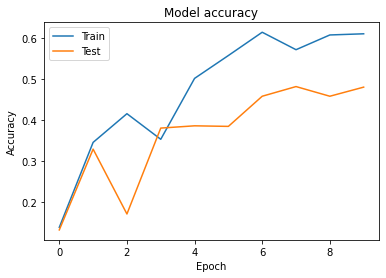

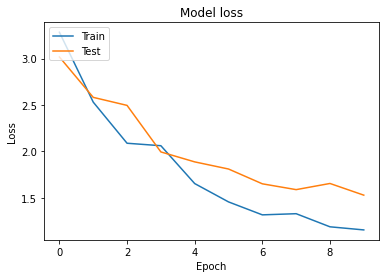

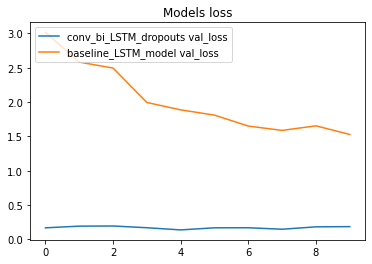

In [66]:
# EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=10)
print(e)

### 0.7819 baseline bi-GRU  model (params: 127,163)
overfits?
```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=simple_bi_GRU_model
Epoch 32/32
loss: 0.0332 - acc: 1.0000 - val_loss: 0.8483 - val_acc: 0.7819
```

In [0]:
def simple_bi_GRU_model(name="new_model"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  Bidirectional(GRU(classes*2, return_sequences=False))(input_text)   
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  
  return model


 
model = simple_bi_GRU_model( simple_bi_GRU_model.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


Model: "simple_bi_GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                125400    
_________________________________________________________________
dense_2 (Dense)              (None, 43)                1763      
Total params: 127,163
Trainable params: 127,163
Non-trainable params: 0
_________________________________________________________________


In [0]:
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=simple_bi_GRU_model
Epoch 1/32
22/22 [==============================] - 111s 5s/step - loss: 2.9966 - acc: 0.4621 - val_loss: 2.4342 - val_acc: 0.5514

Epoch 00001: val_loss improved from inf to 2.43419, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 2/32
22/22 [==============================] - 98s 4s/step - loss: 1.7923 - acc: 0.6941 - val_loss: 1.5961 - val_acc: 0.7139

Epoch 00002: val_loss improved from 2.43419 to 1.59615, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 3/32
22/22 [==============================] - 97s 4s/step - loss: 1.1339 - acc: 0.8258 - val_loss: 1.1960 - val_acc: 0.7222

Epoch 00003: val_loss improved from 1.59615 to 1.19598, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 4/32
22/22 [===================

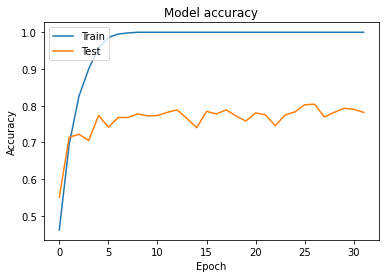

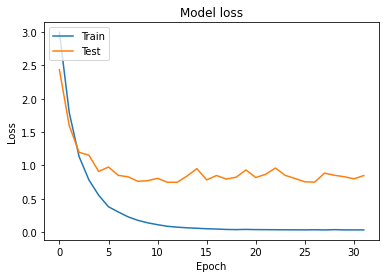

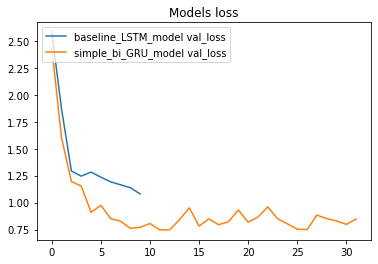

In [0]:

EPOCHS=32
train_and_evaluate_model(model)

In [0]:
model.evaluate_generator(generator=test_generator, steps=100)

In [0]:
model.evaluate_generator(generator=train_generator, steps=100)

### 0.8403 👽 bi-LSTMx16 + dropout (0.1)   (params: 134,667)

```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=simple_bi_LSTM_dropouts
Epoch 20 
loss: 0.0322 - acc: 1.0000 - val_loss: 0.6040 - val_acc: 0.8403
```
 

In [27]:
def simple_bi_LSTM_dropouts(name="new_model"):
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.1, name="drops")(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)   
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  
  
  return model

model = simple_bi_LSTM_dropouts( simple_bi_LSTM_dropouts.__name__ )

from keras.models import load_model
model = load_model(path.join(model_checkpoint_path, model.name))
model.summary()

Model: "simple_bi_LSTM_dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                133248    
_________________________________________________________________
dense_1 (Dense)              (None, 43)                1419      
Total params: 134,667
Trainable params: 134,667
Non-trainable params: 0
_________________________________________________________________


In [28]:
EPOCHS=20
train_and_evaluate_model(model)

MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.05
model.name=simple_bi_LSTM_dropouts
Epoch 1/20
22/22 [==============================] - 149s 7s/step - loss: 0.6903 - acc: 0.8305 - val_loss: 1.1854 - val_acc: 0.6417

Epoch 00001: val_loss improved from inf to 1.18543, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_LSTM_dropouts
Epoch 2/20
22/22 [==============================] - 134s 6s/step - loss: 0.4496 - acc: 0.8532 - val_loss: 1.0084 - val_acc: 0.6597

Epoch 00002: val_loss improved from 1.18543 to 1.00843, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_LSTM_dropouts
Epoch 3/20
22/22 [==============================] - 134s 6s/step - loss: 0.2993 - acc: 0.9328 - val_loss: 0.9138 - val_acc: 0.6778

Epoch 00003: val_loss improved from 1.00843 to 0.91376, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_LSTM_dropouts
Epoch 4/20
22/22 [=

KeyboardInterrupt: ignored

In [0]:
model.evaluate_generator(generator=test_generator, steps=100)

In [0]:
model.evaluate_generator(generator=train_generator, steps=100)

### 0.5014 simple LSTM model + HUuuge Dropouts (params: 172,163)
```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
Epoch 32/32
loss: 0.8510 - acc: 0.6676 - val_loss: 1.3039 - val_acc: 0.5014
```


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "simple_LSTM_model_drops"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                170400    
_________________________________________________________________
dense_3 (Dense)              (None, 43)                1763      
Total params: 172,163
Trainable params: 172,163
Non-trainable params: 0
_________________________________________________________________


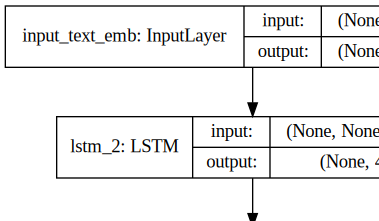

In [0]:

# define baseline model
def simple_LSTM_model_drops(name="no_name"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes*4, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = simple_LSTM_model_drops( simple_LSTM_model_drops.__name__ )
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=simple_LSTM_model_drops
Epoch 1/32
22/22 [==============================] - 97s 4s/step - loss: 3.0215 - acc: 0.2888 - val_loss: 1.9471 - val_acc: 0.3736

Epoch 00001: val_loss improved from inf to 1.94709, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_LSTM_model_drops
Epoch 2/32
22/22 [==============================] - 89s 4s/step - loss: 1.5133 - acc: 0.5227 - val_loss: 1.3196 - val_acc: 0.4944

Epoch 00002: val_loss improved from 1.94709 to 1.31965, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_LSTM_model_drops
Epoch 3/32
22/22 [==============================] - 90s 4s/step - loss: 1.1016 - acc: 0.6136 - val_loss: 1.3108 - val_acc: 0.4778

Epoch 00003: val_loss improved from 1.31965 to 1.31080, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_LSTM_model_drops
Epoch 4/32
22/22 [====

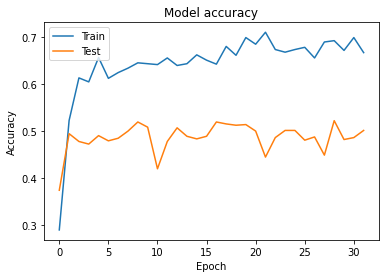

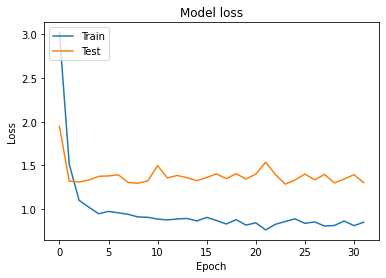

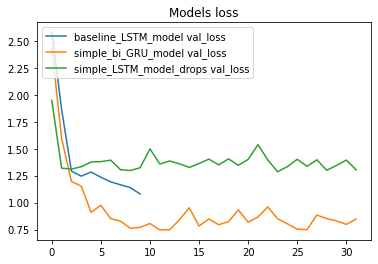

In [0]:
# EPOCHS=16
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

### 0.7347 10-LSTM (+ recurrent_dropout) [ params: 41,873 ]

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
Epoch 10/10
loss: 0.7828 - acc: 0.8030 - val_loss: 0.9723 - val_acc: 0.7347
```

In [0]:

# define baseline model
def smaller_LSTM_model_drops(name="no_name"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = smaller_LSTM_model_drops( smaller_LSTM_model_drops.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

In [0]:
EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

### 0.7417 👙 16-LSTM + Dropout layer (params: 67,355)

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
Dropout 0.05
loss: 0.5523 - acc: 0.8352 - val_loss: 0.7427 - val_acc: 0.7417
```

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.01
loss: 0.5662 - acc: 0.8324 - val_loss: 0.8604 - val_acc: 0.7111
```

In [0]:

# define baseline model
def small_LSTM_model_dropout_l(name="no_name"):
  classes = min(16, CLASSES) 

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	
  dr = Dropout(0.05, name="drops")(input_text)
  # bi =  LSTM(classes, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(dr)  
  bi =  LSTM(classes, return_sequences=False, dropout=0.01, recurrent_dropout=0.01)(dr)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = small_LSTM_model_dropout_l( small_LSTM_model_dropout_l.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

Model: "small_LSTM_model_dropout_l"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                66624     
_________________________________________________________________
dense_4 (Dense)              (None, 43)                731       
Total params: 67,355
Trainable params: 67,355
Non-trainable params: 0
_________________________________________________________________


In [0]:

train_and_evaluate_model(model)

MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=small_LSTM_model_dropout_l
Epoch 1/32
22/22 [==============================] - 100s 5s/step - loss: 3.2460 - acc: 0.3371 - val_loss: 2.8385 - val_acc: 0.3931

Epoch 00001: val_loss improved from inf to 2.83849, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/small_LSTM_model_dropout_l
Epoch 2/32
22/22 [==============================] - 87s 4s/step - loss: 2.3183 - acc: 0.5436 - val_loss: 2.4422 - val_acc: 0.3833

Epoch 00002: val_loss improved from 2.83849 to 2.44216, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/small_LSTM_model_dropout_l
Epoch 3/32
22/22 [==============================] - 87s 4s/step - loss: 1.9370 - acc: 0.5161 - val_loss: 1.8811 - val_acc: 0.3792

Epoch 00003: val_loss improved from 2.44216 to 1.88105, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/small_LSTM_model_dropout_l
Epoch 4/3

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=20)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

### 0.6917 Conv + 43-LSTM (params: 61,380)

```
Epoch 10/10
loss: 0.5654 - acc: 0.8011 - val_loss: 0.6737 - val_acc: 0.7903
```

```
filters = 16
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
model.name=bigger_LSTM_model_noise_l_n1

Epoch 10/10
loss: 0.4150 - acc: 0.8352 - val_loss: 0.8515 - val_acc: 0.6917
```

In [0]:
from keras.layers import GaussianNoise, GaussianDropout, Conv1D

# define baseline model
def bigger_LSTM_model_noise_l(name="no_name"):
  # classes = min(16, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
  _layer = input_text

  _layer = Conv1D( filters = 16, kernel_size=(3), padding='same', activation='relu' )(_layer)

 
  # _layer = GaussianNoise(0.1, name="noise")(_layer)  
  
  _layer = LSTM(CLASSES, return_sequences=False, dropout=0.001, recurrent_dropout=0.001)(_layer)  
  _layer = Dense(CLASSES, activation='softmax')(_layer)


  model = Model(inputs=[input_text], outputs=_layer, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='AdaDelta', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = bigger_LSTM_model_noise_l( bigger_LSTM_model_noise_l.__name__+"_n1" )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

In [0]:
EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=20)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=10)
print(e)

### 0.7667 Conv + 16-LSTM  + Dropout layer (params: 68,395)

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.01
model.name=Conv_16x4_LSTM_d5
Epoch 10
loss: 0.5997 - acc: 0.8201 - val_loss: 0.7436 - val_acc: 0.7667
```

 

In [0]:
from keras.layers import GaussianNoise, GaussianDropout, Conv1D


def Conv_16x4_LSTM(name="no_name"):
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
  _layer = input_text

  _layer = Dropout(0.05, name="drops")(_layer)  
  _layer = Conv1D( filters = 16, kernel_size=(4), padding='same', activation='relu' )(_layer)
  _layer = LSTM(16, return_sequences=False, dropout=0.001, recurrent_dropout=0.001)(_layer)  
  _layer = Dense(CLASSES, activation='softmax')(_layer)


  model = Model(inputs=[input_text], outputs=_layer, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='AdaDelta', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = Conv_16x4_LSTM( Conv_16x4_LSTM.__name__+"_d5" )
 

Model: "Conv_16x4_LSTM_d5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          65552     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 43)                731       
Total params: 68,395
Trainable params: 68,395
Non-trainable params: 0
_________________________________________________________________


In [0]:
# EPOCHS=10
train_and_evaluate_model(model)

MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=Conv_16x4_LSTM_d5
Epoch 1/32
22/22 [==============================] - 106s 5s/step - loss: 3.4064 - acc: 0.1430 - val_loss: 2.9379 - val_acc: 0.1292

Epoch 00001: val_loss improved from inf to 2.93793, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/Conv_16x4_LSTM_d5
Epoch 2/32
22/22 [==============================] - 94s 4s/step - loss: 2.3346 - acc: 0.3182 - val_loss: 1.8815 - val_acc: 0.3736

Epoch 00002: val_loss improved from 2.93793 to 1.88150, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/Conv_16x4_LSTM_d5
Epoch 3/32
22/22 [==============================] - 98s 4s/step - loss: 1.6666 - acc: 0.5085 - val_loss: 1.5626 - val_acc: 0.4153

Epoch 00003: val_loss improved from 1.88150 to 1.56262, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/Conv_16x4_LSTM_d5
Epoch 4/32
22/22 [===========================

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=20)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=10)
print(e)

### 👽👽 0.9583 Сonv + maxPool + bi-LSTMx16 +  dropout (0.1)   (params: 136,731)

```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.05

Epoch 20
loss: 0.0206 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9417

Epoch 40
loss: 0.0185 - acc: 1.0000 - val_loss: 0.1850 - val_acc: 0.9583
```
 

In [22]:
from keras.layers import MaxPooling1D
def conv_bi_LSTM_dropouts(name="new_model"):
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.1, name="drops")(_out)
  _out = Conv1D( filters = 16, kernel_size=(8), padding='same', activation='relu' )(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)   
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model

model = conv_bi_LSTM_dropouts( conv_bi_LSTM_dropouts.__name__+"_rev" )







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Model: "conv_bi_LSTM_dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          131088    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_6 (Dense)              (None, 43)                1419      
Total params: 136,731
Trainable params: 136,731
Non-trainable params: 0
_______________________________________

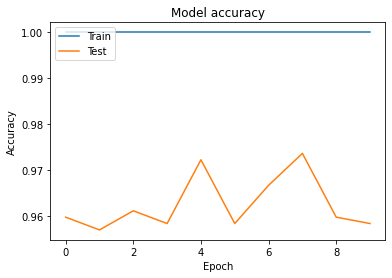

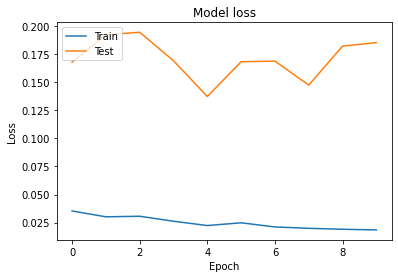

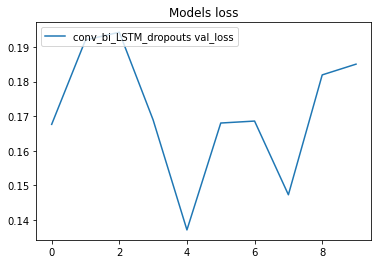

In [64]:
from keras.models import load_model
model1 = load_model(path.join(model_checkpoint_path, conv_bi_LSTM_dropouts.__name__))
model1.summary()
EPOCHS=10
train_and_evaluate_model(model1)

In [0]:
EPOCHS=20
train_and_evaluate_model(model)

MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.05
model.name=conv_bi_LSTM_dropouts_rev
Epoch 1/20
22/22 [==============================] - 171s 8s/step - loss: 2.6756 - acc: 0.4867 - val_loss: 1.5879 - val_acc: 0.6847

Epoch 00001: val_loss improved from inf to 1.58792, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_rev
Epoch 2/20
22/22 [==============================] - 153s 7s/step - loss: 1.0923 - acc: 0.9233 - val_loss: 0.6384 - val_acc: 0.9819

Epoch 00002: val_loss improved from 1.58792 to 0.63843, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_rev
Epoch 3/20
22/22 [==============================] - 156s 7s/step - loss: 0.4720 - acc: 0.9943 - val_loss: 0.3241 - val_acc: 0.9986

Epoch 00003: val_loss improved from 0.63843 to 0.32410, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_rev
Epoch 4/20


#Train final model

### conv_bi_LSTM_dropouts_final

```
EMB_NOISE_AMOUNT=0.05
conv_bi_LSTM_dropouts_final

Epoch 40/40
loss: 0.0087 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 1.0000
```

MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.05
model.name=conv_bi_LSTM_dropouts_final
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/40





23/23 [==============================] - 227s 10s/step - loss: 2.8053 - acc: 0.4692 - val_loss: 1.7348 - val_acc: 0.9263

Epoch 00001: val_loss improved from inf to 1.73479, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_final
Epoch 2/40
23/23 [==============================] - 176s 8s/step - loss: 1.2242 - acc: 0.9049 - val_loss: 1.4538 - val_acc: 0.6731

Epoch 00002: val_loss improved from 1.73479 to 1.45377, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_final
Epoch 3/40
23/23 [==============================] - 170s 7s/step - loss: 0.8778 - acc: 0.9103 - val_loss: 0.5487 - val_acc: 0.9984

Epoch 00003: val_loss improved from 1.45377 to 0.54872, saving m

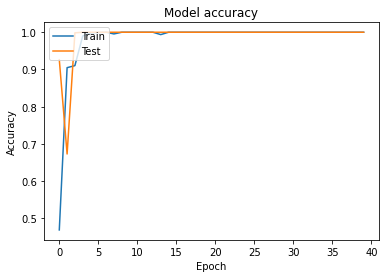

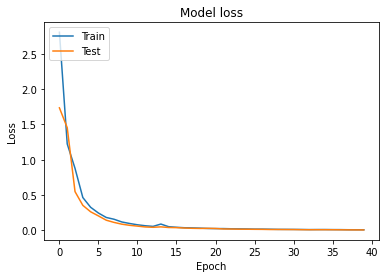

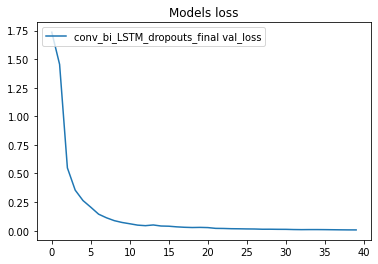

In [24]:
# generator

EPOCHS =40
all_generator = subj_batch_generator(BATCH_SIZE, all_indices = train_indices+test_indices, randomize=True)
final_model = conv_bi_LSTM_dropouts( conv_bi_LSTM_dropouts.__name__+"_final" )
train_and_evaluate_model(final_model, generator=all_generator)

# Playground

#### load model

In [54]:
model_name = conv_bi_LSTM_dropouts.__name__+""
from keras.models import load_model
model1 = load_model(path.join(model_checkpoint_path, model_name))
model1.summary()

Model: "conv_bi_LSTM_dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          131088    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_6 (Dense)              (None, 43)                1419      
Total params: 136,731
Trainable params: 136,731
Non-trainable params: 0
_______________________________________

#### Predict

In [0]:
# model=final_model
model=model1
row_no:int=0

prediction_col_name='predicted_subj'
model_validation_meta = trainset_meta[ trainset_meta['subject']!='?' ].copy()
model_validation_meta[prediction_col_name]='?'
model_validation_meta[prediction_col_name+"_conf"]=0.0
model_validation_meta[prediction_col_name+"_valid"]=False

for index, row in model_validation_meta.iterrows():
  row_by_no = model_validation_meta.iloc[row_no]

  _subj=row_by_no['subject']
  _filename=row_by_no['pickle']   
  
  _emb = get_embeddings_raw(_filename)  
  _onehot = subject_name_1hot_map[ _subj ]


  result = model.predict( np.array( []+ [_emb]) )
  max_i=result[0].argmax()
  predicted_subj_name=ContractSubject(max_i).name

  model_validation_meta[prediction_col_name][index]  = predicted_subj_name
  model_validation_meta[prediction_col_name+"_conf"][index]  = result[0][max_i]
  model_validation_meta[prediction_col_name+"_valid"][index]  = predicted_subj_name==_subj

  print(row_no, index, _subj,'-->', predicted_subj_name, row_by_no['valid'], result[0][max_i] )
  

  if row_no%5==0:
    model_validation_meta.to_csv(path.join(model_checkpoint_path, model.name)+'.csv', encoding='utf-8', index=True)
    model_validation_meta.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

  row_no+=1

  # if row_no > 21:
  #   break

model_validation_meta.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

In [0]:

model_validation_meta[model_validation_meta[prediction_col_name] != '?']